# Question 1

Suppose $X_1, X_2, \cdots, X_n \sim F$ (i.i.d. draws) and $Y_1, Y_2, \cdots, Y_n$ is a Markov Chain with $F$ as the stationary distribution. Consider two estimates of the mean:
$$
\bar{X} = \frac{1}{n}\sum_{i=1}^n X_i \\
\bar{Y} = \frac{1}{n}\sum_{i=1}^n Y_i
$$
Which estimator is better? Support with formal mathematical arguments.

## Solution

The estimator $\bar{X}$ is better because it's the sample mean of $X$ that is sampled directly from $F$, while the samples $Y$ have been estimated to be sampled from the distribution $F$ through Markov Chains. We may assume that $Y$ is sampled from $F$ after a burnout threshold, but it's always nearly sampled.  
This leads to $\bar{Y}$ being the sample mean of samples from a distribution that simulates $F$ but isn't, while $X$ is exactly from $F$.

EDIT: An estimator is better, the lower is its Bias + Variance. Even if unbiased estimators are assumed, it's unclear to make a prior over which estimator would be better, given no evidence about either of them.

# Question 2

Suppose $Y_1, Y_2, \cdots, Y_n \hspace{4pt}\vert \hspace{4pt} \mu \sim N(\mu, 1)$.  Assume the prior on $\mu \sim t_\nu$, where $\nu$ is the degrees of freedom. Assume the prior on $\nu \sim \textit{Truncated Gamma}(a_0, b_0, (2, \infty))$, where $(2, \infty)$ is the support of the same.
- What is the joint posterior distribution of $(\mu, \nu)$
- Write an Metropolis-Hastings algorithm to sample from the above posterior distribution.
- Generate n = 100 data points. Set $a_0 = 2, b_0 = 0.1$, and run the MH algorithm mentioned above

## Solution

Posterior belief $\propto$ Evidence * Prior belief $\implies P(\lambda \vert Y) = \frac{P(Y \vert \lambda) P(\lambda)}{P(Y)}$.  
This is equivalent to if $\lambda = (\mu, \nu)$ then $P(\lambda \vert Y) \propto P(Y \vert \mu) P(\mu) = P(Y \vert \mu) P(\mu \vert \nu) P(\nu)$  
$\implies N(\mu, 1) * t(\nu) * \textit{Truncated Gamma}(a_0, b_0, (2, \infty))$

Therefore,
$$
\pi((\mu, \nu) \vert X) = f(X \vert (\mu, \nu)) f(\mu \vert \nu) f(\nu) \\
\ni f(X \mid (\mu, \nu)) \propto \prod exp \left(\frac{(x_i - \mu)^2}{2}\right) \\
f(\mu \mid \nu) \propto \left(1 + \frac{\mu^2}{\nu}\right)^{\frac{-\nu + 1}{2}} \\
f(\nu) \propto \nu^{a_0 - 1} e^{-\frac{\nu}{b_0}} I(2, \infty)
$$

In [1]:
using Statistics
using Distributions
using Random
using Plots
Random.seed!(13);

In [2]:
a₀, b₀ = 2, 0.1;
n = 100;

### Initiating evidences

In [3]:
truncated_gamma = truncated(Gamma(a₀, b₀), lower=2);
ν_implicit = rand(truncated_gamma)
student_t = TDist(ν_implicit);
μ_implicit = rand(student_t)
normal = Normal(μ_implicit, 1);
Y = rand(normal, n); # actual data that may have been received
μ_implicit, ν_implicit, size(Y), mean(Y)
# these are the actual values of μ, ν that won't be given in a real scenario

(0.8952896226716844, 2.0172371377074256, (100,), 0.8920106788032421)

In [4]:
function posterior_pdf(λ)
    #=
    Returns the posterior pdf value at x, upto a proportionality constant
    λ := [μ, ν]
    =#
    μ = λ[1]
    ν = λ[2]
    if ν < 2
        return 0
    end
    i = ν ≥ 2 ? 1 : 0
    g = ν^(a₀-1)*exp(-ν/b₀)
    t = (1 + μ^2/ν)^(-(ν+1)/2)
    p = map(v -> exp(-(v-μ)^2/2), Y)
    p = reduce(*, p);
    return p*t*(g*i)
end

posterior_pdf (generic function with 1 method)

In [5]:
function proposal_pdf(x_new, x_curr, var)
    #=
    Returns the proposal pdf value at x, upto a proportionality constant
    =#
    μ, ν = x_curr[1], x_curr[2]
    μ_new, ν_new = x_new[1], x_new[2]
    var_μ, var_ν = var
    return exp(-(μ_new-μ)^2/(2*var_μ) -(ν_new-ν)^2/(2*var_ν))
    # essentially gives back 1 every time, because of symmetric proposal
end

proposal_pdf (generic function with 1 method)

In [6]:
function metropolis_hastings(n, λ, var)
    #=
    n : Number of samples to be taken from posterior
    λ : Initial values set for μ and ν
    var : Hyperparameters for proposal distribution for λ
    =#
    n *= 2
    var_μ = var[1]
    var_ν = var[2]
    samples = zeros(n, 2)
    accepted = 0
    for i=1:n
        samples[i, :] = λ
        λ_new = zeros(1, 2)
        λ_new[1] = rand(Normal(λ[1], var_μ))
        λ_new[2] = rand(Normal(λ[2], var_ν))
        posterior_ratio = posterior_pdf(λ_new)/posterior_pdf(λ)
        proposal_ratio = proposal_pdf(λ, λ_new, var)/proposal_pdf(λ_new, λ, var)
        α = min(1, proposal_ratio*posterior_ratio)

        u = rand(Uniform())
        if u < α
            accepted += 1;
            λ = λ_new
        end
    end
    return samples[Int(n/2)+1:end, :], accepted/n;
end

metropolis_hastings (generic function with 1 method)

In [7]:
λ = [mean(Y), 2.105]; # means of samples is μ
var_ = (0.2, 0.2)
println("Initial Values: ", λ)
data_λ, acceptance_rate = metropolis_hastings(10000, λ, var_);
mu_samples = data_λ[:, 1]
nu_samples = data_λ[:, 2]
println("Acceptance Rate: $acceptance_rate")

Initial Values: [0.8920106788032421, 2.105]
Acceptance Rate: 0.21765


For μ:
Mean: 0.8895575366857729
Variance: 0.010280852022838563


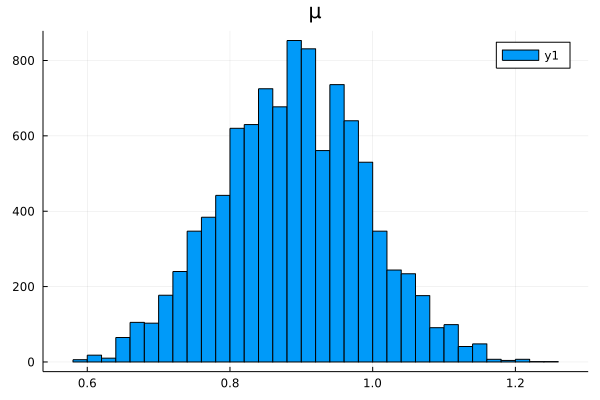

In [8]:
println("For μ:")
println("Mean: ", mean(mu_samples))
println("Variance: ", var(mu_samples))
histogram(mu_samples, title="μ")

For ν:
Mean: 2.1077287113318888
Variance: 0.011946559379202538


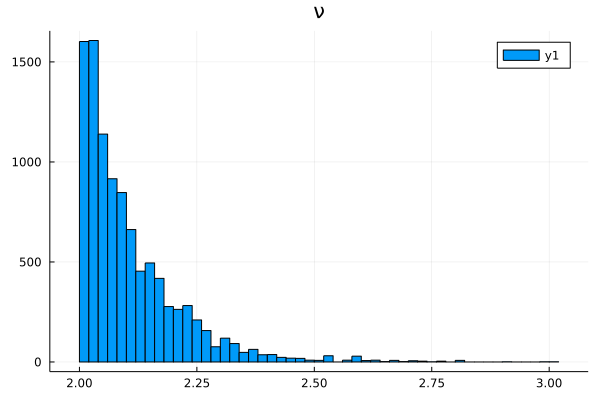

In [9]:
println("For ν:")
println("Mean: ", mean(nu_samples))
println("Variance: ", var(nu_samples))
histogram(nu_samples, title="ν")

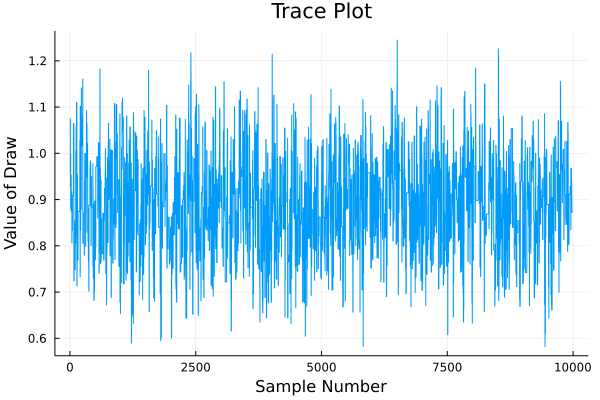

In [10]:
plot(mu_samples, color=1, label="", xlabel="Sample Number", ylabel="Value of Draw", title="Trace Plot")

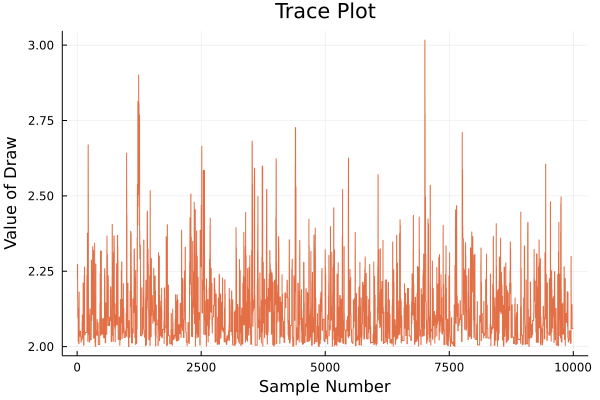

In [11]:
plot(nu_samples, color=2, label="", xlabel="Sample Number", ylabel="Value of Draw", title="Trace Plot")

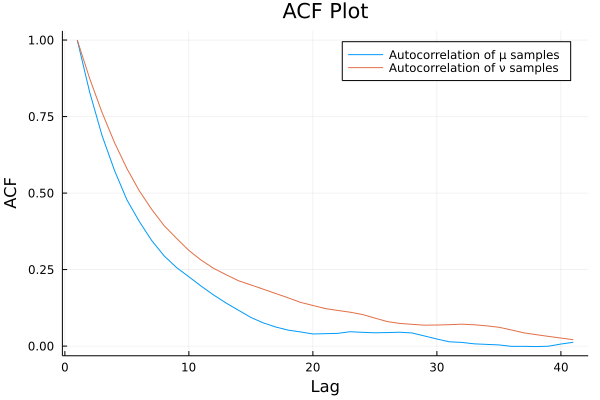

In [12]:
using StatsBase
plot(autocor(mu_samples), color=1, label="Autocorrelation of μ samples", xlabel="Lag", ylabel="ACF", title="ACF Plot")
plot!(autocor(nu_samples), color=2, label="Autocorrelation of ν samples", xlabel="Lag", ylabel="ACF", title="ACF Plot")

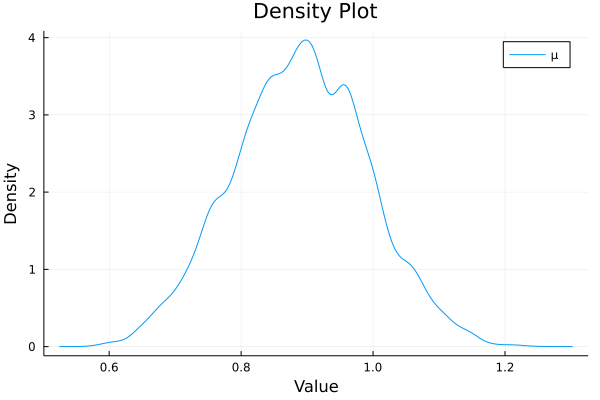

In [13]:
using StatsPlots
plot(density(mu_samples, color=1, label="μ"), title="Density Plot", xlabel="Value", ylabel="Density")

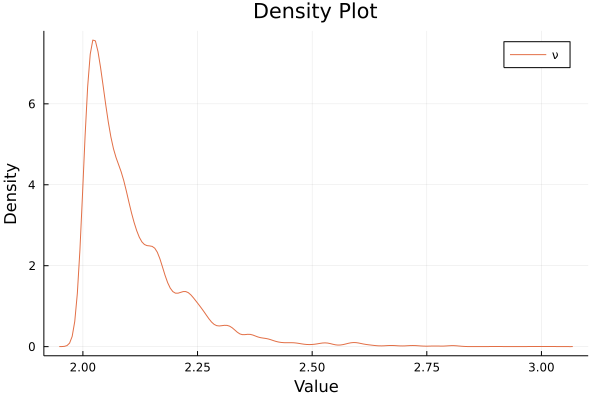

In [14]:
plot(density(nu_samples, color=2, label="ν"), title="Density Plot", xlabel="Value", ylabel="Density")

In [15]:
println("Actual values:")
println("Actual μ : $μ_implicit")
println("Actual ν : $ν_implicit")
mean_samples = mean(Y)
var_samples = var(Y)
println("Inferred values from samples with mean $mean_samples and var $var_samples:")
mean_μ = mean(data_λ[:, 1])
mean_ν = mean(data_λ[:, 2])
var_μ = var(data_λ[:, 1])
var_ν = var(data_λ[:, 2])
println("μ : mean $mean_μ, var $var_μ")
println("ν : mean $mean_ν, var $var_ν")

Actual values:
Actual μ : 0.8952896226716844
Actual ν : 2.0172371377074256
Inferred values from samples with mean 0.8920106788032421 and var 0.9485297420246616:
μ : mean 0.8895575366857729, var 0.010280852022838563
ν : mean 2.1077287113318888, var 0.011946559379202538


# Question 3

Consider the Bayesian linear regression model. The likelihood is $y_1, y_2, \cdots, y_n \hspace{4pt} \vert \hspace{4pt} \beta, \sigma^2 \sim N_n(X\beta, \sigma^2 I_n)$ just like regular MLE. We assume priors: $\beta \sim N_p(\mu, \sigma^2 I_p)$ and $\sigma^2 \sim \textit{Inverse Gamma }(a, b)$.
$N_p$ is the p-dimensional multivariate normal distribution and density of $\textit{Inverse Gamma}(a, b)$ is given as:
$$
\pi(\sigma^2) \propto e^{-b/\sigma^2} \left(\frac{1}{\sigma^2}\right)^{-a+1}
$$
Here $a$, $b$ and $\mu$ are hyper-parameters, which need to be chosen according to the dataset.
- What is the posterior distribution of $(\beta, \sigma^2)$
- Implement an MH algorithm to sample from the posterior distribution for any suitable dataset

## Solution

> Posterior belief $\propto$ Evidence * Prior belief
  
Let $\lambda$ be the model parameters, i.e. $\beta$ being weights $(p \times 1)$ for regression, $\sigma^2$ introducing variance to frequentist approach.  
$P(\lambda \vert Y) = \frac{P(Y \vert \lambda) P (\lambda)}{P(Y)}$. This can be interpreted as getting the distribution of $\lambda$ after observing $Y$ being sampled from the prior distribution which $\lambda$ had.

Posterior distribution $P(\lambda \vert Y)$
$$
\propto P(Y \vert (\beta, \sigma^2)) P(\beta \vert \sigma^2) P(\sigma^2) \\
\propto N_n(X\beta, \sigma^2 I_n) * N_p(\mu, \sigma^2 I_p) * e^{-b/\sigma^2} \left(\frac{1}{\sigma^2}\right)^{-a+1} \\
\propto e^{-\frac{1}{2}(x-X\beta)^T\Sigma^{-1}(x-X\beta)} * e^{-\frac{1}{2}(\beta-\mu)^T\Sigma^{-1}(\beta-\mu)} * e^{-b/\sigma^2} \left(\frac{1}{\sigma^2}\right)^{-a+1} \\
\propto \frac{1}{\sigma^{p}} e^{-\frac{1}{2}\frac{(x-X\beta)^T (x-X\beta)}{\sigma^2}}* e^{-\frac{1}{2}\frac{(\beta-\mu)^T (\beta-\mu)}{\sigma^2}}* e^{-\frac{b}{\sigma^2}} \left(\frac{1}{\sigma^2}\right)^{-a+1}
$$

For sampling the posterior, we have to make the proposal for 13 actual columns of dataset, 1 bias column, and $\sigma^2$. I'll use the normal distribution for all these, thus an uncorrelated multinormal of 15 dimensions.

In [16]:
using CSV
using DataFrames
using Plots
using Statistics
using StatsPlots
using GLM; # for lm
# using MLBase
using LinearAlgebra # for I

In [17]:
a = 3;
b = 4;
var_proposal = 40; # uncorrelated multinormal proposal variance
μ = rand(14)

14-element Vector{Float64}:
 0.006016603347782756
 0.3961367167365719
 0.027600683834397954
 0.7088740086380262
 0.3040719359710242
 0.255665496148312
 0.8085174245655743
 0.7505577305969839
 0.9181667963489504
 0.13280739066490677
 0.8395380750727104
 0.8429789037080917
 0.5097246558718515
 0.33888437886051237

In [18]:
# data loading
df = DataFrame(CSV.File("./housing.csv"))

m = size(df)[1]
train_m = Int(floor(m*0.75))
p = size(df)[2]

14

In [19]:
df_train = df[1:train_m, :];
m = size(df_train)[1]
X = df_train[:, 1:end-1];
y = df_train[:, end];
X_test = df[train_m+1:end, 1:end-1];
y_test = df[train_m+1:end, end];

# adding a bias column
X = DataFrame(hcat(ones(m), X))
X_test = DataFrame(hcat(ones(size(y_test)[1]), X_test));
m, p = size(X)
println(m, ", ", p, ", ", names(X))

379, 14, ["x1", "CRIM", "ZN", "INDUS", "CHAS", "NOX", "RM", "AGE", "DIS", "RAD", "TAX", "PTRATIO", "B", "LSTAT"]


In [20]:
# a way is initialising as the linear regression fit
fm = @formula(MEDV ~ (CRIM + ZN + INDUS + CHAS + NOX + RM + AGE + DIS + RAD + TAX + PTRATIO + B + LSTAT))
linearRegress = lm(fm, df_train)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}}}}, Matrix{Float64}}

MEDV ~ 1 + CRIM + ZN + INDUS + CHAS + NOX + RM + AGE + DIS + RAD + TAX + PTRATIO + B + LSTAT

Coefficients:
─────────────────────────────────────────────────────────────────────────────────
                    Coef.  Std. Error      t  Pr(>|t|)     Lower 95%    Upper 95%
─────────────────────────────────────────────────────────────────────────────────
(Intercept)   23.406       6.05307      3.87    0.0001   11.5027      35.3093
CRIM          -0.162647    0.16542     -0.98    0.3261   -0.487943     0.162648
ZN             0.0454534   0.0137547    3.30    0.0010    0.018405     0.0725018
INDUS          0.0681541   0.0637334    1.07    0.2856   -0.0571766    0.193485
CHAS           0.859133    0.883389     0.97    0.3314   -0.878037     2.5963
NOX          -15.5144      4.43441     -3.50    0.0005  -24.2346      -6.79418
RM    

In [21]:
β = coef(linearRegress)
println(β)

[23.40597844082577, -0.16264715053346532, 0.04545340530833858, 0.06815406054790957, 0.8591334841647331, -15.51438005686637, 5.321600126889647, -0.0014013494403386487, -1.3111691332778377, 0.6173814962995712, -0.014652732792313493, -0.8092809387561265, 0.002759099113152454, -0.45481089020278115]


In [22]:
function Base.max(v1::Array)
    ma = -1e9
    for i in v1
        if ma < i
            ma = i;
        end
    end
    return ma
end

function Base.min(v1::Array)
    mi = 1e9
    for i in v1
        if mi > i
            mi = i;
        end
    end
    return mi
end

function mse_(v1, v2)
    @assert isequal(size(v1), size(v2));
    v1 = v1./(max(v1)-min(v2))
    v2 = v2./(max(v2)-min(v2))
    err = 0
    for i=1:size(v1)[1]
        err = (v1[i] - v2[i])^2
    end
    return err/size(v1)[1]*10000; # 10000 scaling factor
end

mse_ (generic function with 1 method)

Correlation: 0.8540008000131837
MSE: 2.1918354104350257


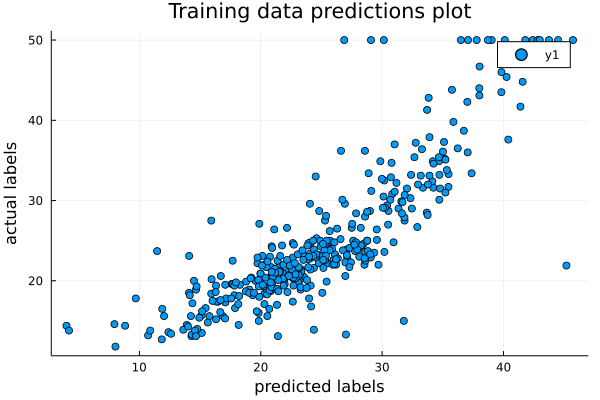

In [23]:
X_arr = Matrix(X)
pred = X_arr * β
println("Correlation: ", cor(pred, y))
println("MSE: ", mse_(pred, y));
scatter(pred, y, ylabel="actual labels", xlabel="predicted labels", title="Training data predictions plot")

Correlation: 0.5843084739287835
MSE: 3.935623578493794


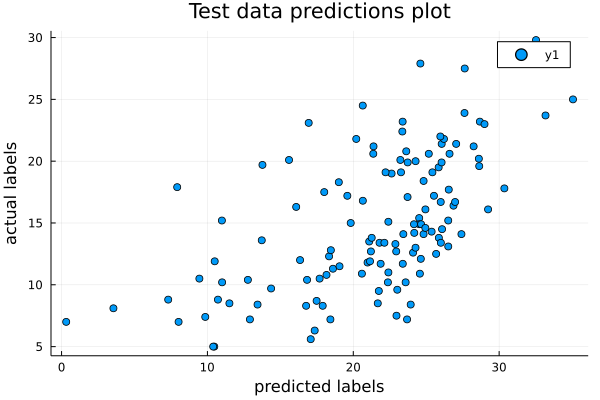

In [24]:
X_arr = Matrix(X_test)
pred = X_arr * β
println("Correlation: ", cor(pred, y_test))
println("MSE: ", mse_(pred, y_test));
scatter(pred, y_test, ylabel="actual labels", xlabel="predicted labels", title="Test data predictions plot")

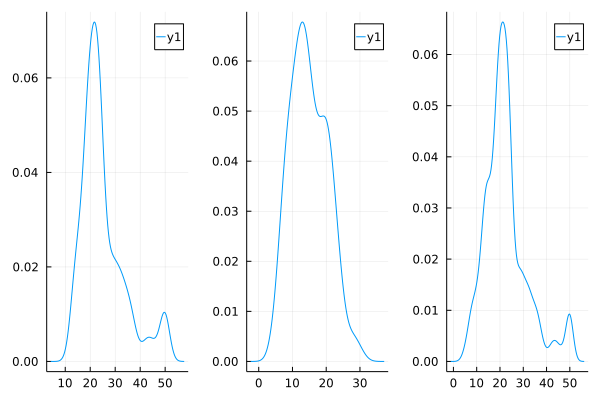

In [25]:
plot(density(y), density(y_test), density(df[:, end]), layout=(1, 3))

In [26]:
X_arr = Matrix(X)

for i in 1:p
    X_arr[:,i] = convert.(Float64, X[:,i])
    X_arr[:,i] = X[:,i]./sum(X_arr[:,i])
end

y = y./sum(y)

379-element Vector{Float64}:
 0.0025254651064904455
 0.002272918595841401
 0.0036514016331341027
 0.0035146056065325365
 0.0038092432022897556
 0.0030200353565114912
 0.002409714622442967
 0.002851671016078795
 0.0017362572607121814
 0.0019888037713612257
 0.0015784156915565285
 0.0019888037713612257
 0.0022834413671184444
 ⋮
 0.002430760164997054
 0.005261385638521762
 0.005261385638521762
 0.005261385638521762
 0.005261385638521762
 0.005261385638521762
 0.0014521424362320063
 0.0014521424362320063
 0.0015784156915565285
 0.0014626652075090498
 0.0013995285798467888
 0.0013784830372927015

In [27]:
function posterior_pdf(λ)
    #=
    λ : tuple containing β and σ^2
    =#
    β = λ[1:end-1]
    σ_sq = λ[end]
    arr = y - X_arr*β
    n = -0.5*transpose(arr)*arr
    p = -0.5*transpose(β-μ)*(β-μ)
    g = -b
#     println("Mid: ", n, ", ", p, ", ", g)
    r1 = exp((n+p+g)/σ_sq)
    r2 = (1/σ_sq)^(-a+1)
    return r1*r2
end

posterior_pdf (generic function with 1 method)

In [28]:
function proposal_pdf(x_new, x_curr)
    #=
    Proposal distribution that has the same support as posterior
    p-dim Normal distribution
    =#
    return exp(-(transpose(x_new - x_curr)*(x_new - x_curr))/(2*var_proposal))
end

proposal_pdf (generic function with 2 methods)

Mean: 1.9446496156633695


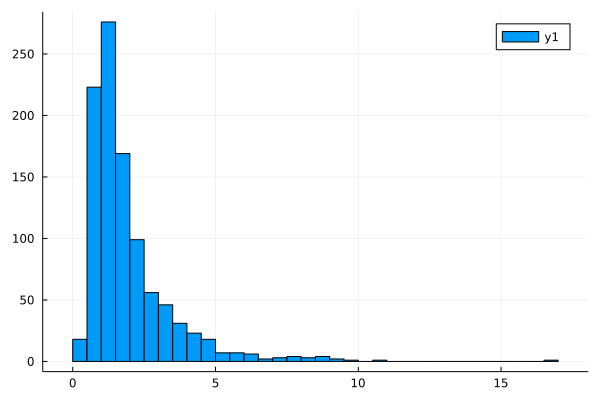

In [29]:
# for initial value of σ²
v = rand(InverseGamma(a, b), 1000)
σ_sq = mean(v)
println("Mean: ", σ_sq)
histogram(v)

In [30]:
function metropolis_hastings(n, λ)
    #=
    n : number of samples to be sampled from posterior
    λ : array containing β and σ² initial values
    =#
    n *= 2 # dump off 50% later
    samples = zeros(n, p+1) # first p elements of a row is β, last element is σ²
    idx = 1
    accepted = 0
    while idx <= n
        samples[idx, :] = λ
#         println(idx)
#         println(λ)
#         println()
        idx += 1

        # norm_dist = MvNormal(λ[1:end-1], λ[end]*I)
        # β_sample = rand(norm_dist)
        # igamma_dist = InverseGamma(a, b)
        # σ_sq_sample = rand(igamma_dist)
        # λ_new = push!(β_sample, σ_sq_sample)
        λ_new = rand(MvNormal(λ, var_proposal*I))

        # checking if x_new would give higher posterior belief, or x_curr would
        ratio_posterior = posterior_pdf(λ_new)/posterior_pdf(λ)
        ratio_proposal = proposal_pdf(λ, λ_new)/proposal_pdf(λ_new, λ)
        α = min(1, ratio_posterior*ratio_proposal)
#         println(α)
        
        # updating x_curr with probability of α
        u = rand(Uniform(), 1)[1]
        if u < α
#             println(ratio_posterior)
#             println(ratio_proposal)
            accepted += 1
            λ = λ_new
        end
    end
    return samples[Int(n/2)+1:end, :], accepted/n
end

metropolis_hastings (generic function with 2 methods)

In [31]:
# β = randn(p); # another way of initialising β
# σ_sq = 2
n = 1000
init = [β..., σ_sq]
# println(init)
samples, acceptance_rate = metropolis_hastings(n, init)
acceptance_rate

0.474

In [32]:
β_samples = samples[:, 1:end-1];
σ_sq_samples = samples[:, end];
;

In [33]:
density_plots=[] 
acf_plots=[]
trace_plots=[]
for i in 1:p
    p1=plot(density(samples[:,i],color=4,label="β$i"))
    p2=plot(samples[:,i],color=4,label="β$i")
    p3=plot(autocor(samples[:,i]),color=4,label="β$i")
    push!(density_plots,p1)
    push!(acf_plots,p3)
    push!(trace_plots,p2)
end
p1=plot(density(samples[:,p+1],color=2,label="σ²"))
p2=plot(samples[:,p+1],color=2,label="σ²")
p3=plot(autocor(samples[:,p+1]),color=2,label="σ²")
push!(density_plots,p1);
push!(acf_plots,p3);
push!(trace_plots,p2);

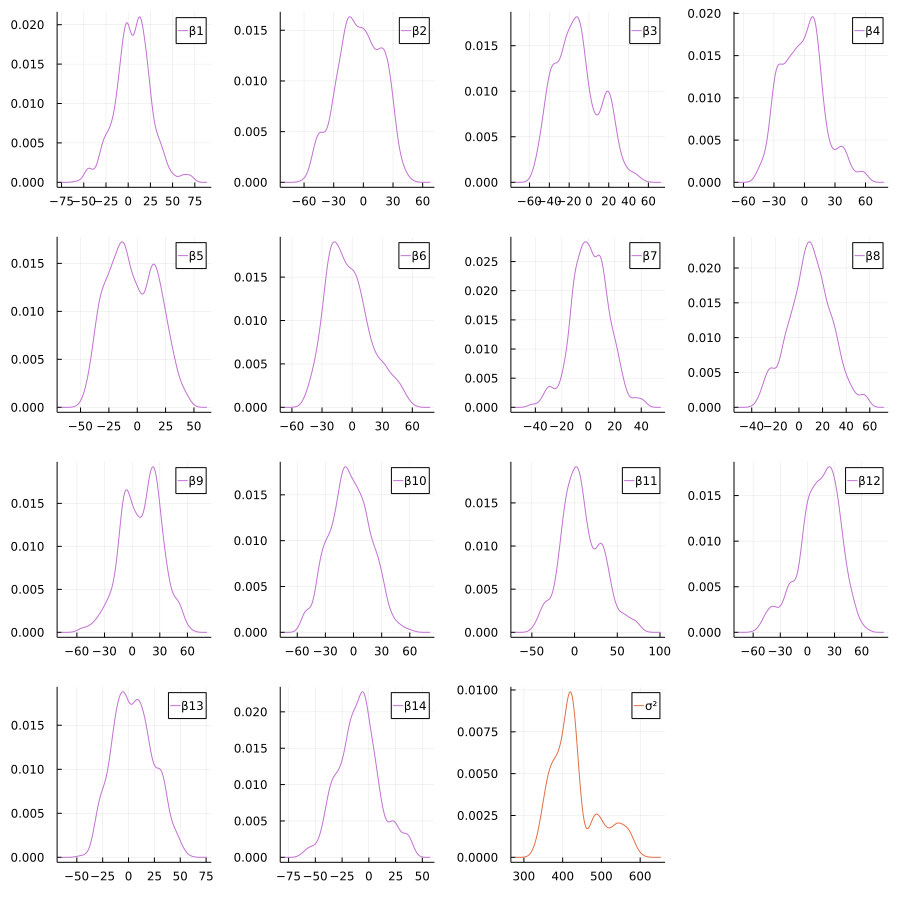

In [34]:
plot(density_plots...)
plot!(size=(900,900))

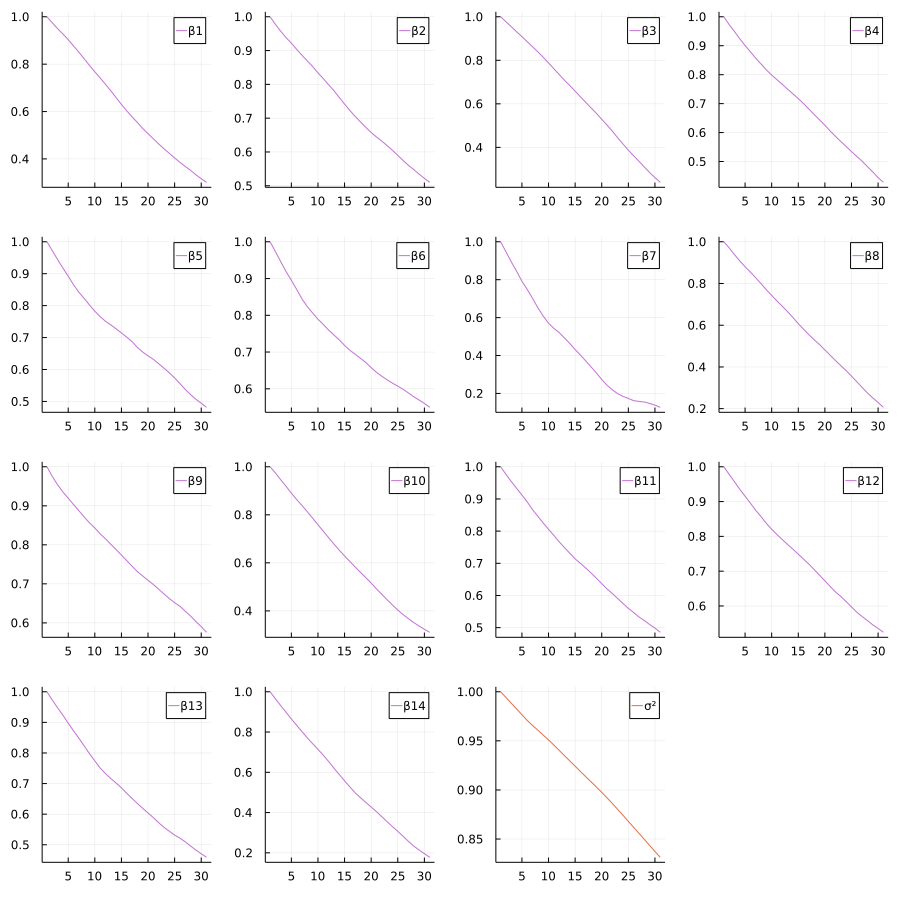

In [35]:
plot(acf_plots...)
plot!(size=(900,900))

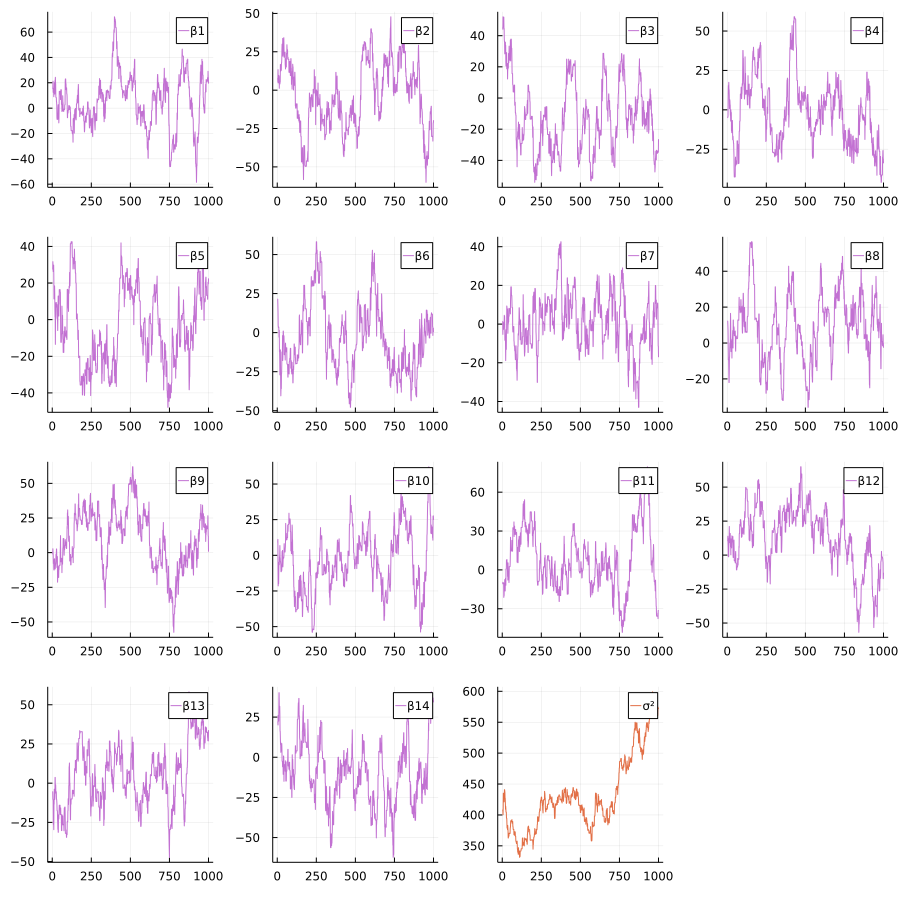

In [36]:
plot(trace_plots...)
plot!(size=(900,900))

By tampering with a, b, $\mu$ and var_proposal, we can make ACF of each feature, more uncorrelated as lag increases. This is the best I found with a few trials.